Gerrychain is not installed on Colab, so first we have to install it.

In [2]:
!pip install gerrychain
!pip install maup

This code attempts to install a jupyter notebook extension which renders code output in markdown. It does not appear to work, although it installs and enables fine.

In [ ]:
!pip install https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tarball/master
!jupyter contrib nbextension install --user
!jupyter nbextension enable --user
!jupyter nbextension enable python-markdown/main

     - 29.4MB 24.7MB/s
     |████████████████████████████████| 870kB 4.1MB/s 
     |████████████████████████████████| 481kB 16.8MB/s 
  Created wheel for jupyter-contrib-nbextensions: filename=jupyter_contrib_nbextensions-0.5.1-py2.py3-none-any.whl size=23430599 sha256=11bab80ee3da71c0c289a096e197a41e795fd4e4e0cca2ea702845f2462744e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-nhzctm9a/wheels/22/4a/9f/df59e985684a10ea0e025300581870b5b3a300ee3525f0eef5
  Created wheel for jupyter-latex-envs: filename=jupyter_latex_envs-1.4.6-py2.py3-none-any.whl size=963395 sha256=f1b5184165e425c1f0f75e97e0c80d829d2d21b4a240d46bae285c5f93175a29
  Stored in directory: /root/.cache/pip/wheels/0d/71/2a/164491997299b9f2479a251e254323fe35d946779e18f27956
  Created wheel for jupyter-nbextensions-configurator: filename=jupyter_nbextensions_configurator-0.4.1-py2.py3-none-any.whl size=465825 sha256=c125c9a80c0d1bef9beaa567486bbcbf0e6c491a0b23ed45abede3550a913a8d
  Stored in directory: /root/.cache/pip/whee

In [ ]:

a = 3

The following statement should read "The variable is 3": 
The variable a is {{a}}

# MAUP for preparing the shape file

We use maup and geopandas to aggregate the data we care about into a single shape file for analysis of a particular plan, and as a seed for MCMC random district generation (next section).

First, we import the packages we need.

In [ ]:
#here we may want to clone a github repository - for now, we manually upload the desired files TX_vtds, sen_18, and any congressional plans we'd like to use

In [ ]:
import warnings; warnings.filterwarnings('ignore','GeoSeries.isna',UserWarning)

In [ ]:
import geopandas as gpd
import maup
import matplotlib.pyplot as plt
import pandas as pd
import numpy

We need to upload a shape file of Texas voter tabulation districts (VTDs). This is available for download here https://people.csail.mit.edu/ddeford/TX_vtds.zip - thanks to Daryl Deford for hosting it.

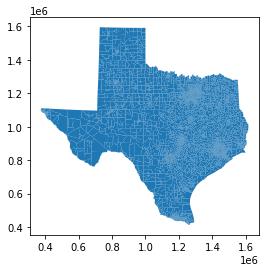

In [ ]:
vtds = gpd.read_file("/content/TX_vtds.shp")
vtds.plot()

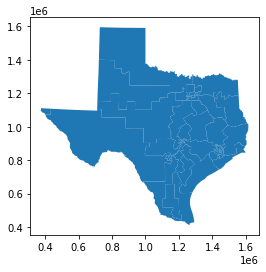

In [ ]:
plan2011 = gpd.read_file("/content/PLANC185.shp")
plan2011.plot()

To combine the two shape files, we must make sure that they have the same projection. To do this, we get the projection of the vtd file, and then set the 2012 plan to this projection.

In [ ]:
plan2011 = plan2011.to_crs(vtds.crs)
plan2011.crs

<Projected CRS: EPSG:3081>
Name: NAD83 / Texas State Mapping System
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA - Texas
- bounds: (-106.66, 25.83, -93.5, 36.5)
Coordinate Operation:
- name: Texas State Mapping System (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

maup.assign takes two arguments, a source, and then a target. It assigns source geometries to target geometries - in this case, vtds to districts of the 2011 plan. This may take a couple minutes. We then add this assignment as a column in the vtds dataframe.

In [ ]:
vtds.geometry = vtds.geometry.buffer(0)
plan2011.geometry = plan2011.geometry.buffer(0)
assignment = maup.assign(vtds,plan2011.set_index('District'))

In [ ]:
vtds['2011 plan']=assignment

We then plot our districts to see if they looks reasonable

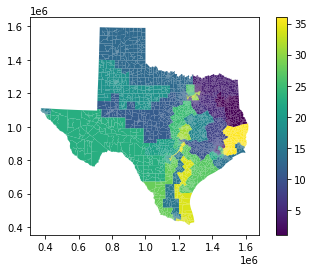

In [ ]:
vtds.plot(column='2011 plan',legend=True)

Checking population balance

In [ ]:
district_demographics = vtds.groupby('2011 plan').sum()['TOTPOP']
district_demographics.head()

2011 plan
1    698488.0
2    700845.0
3    698488.0
4    698488.0
5    698488.0
Name: TOTPOP, dtype: float64

The next thing will be to add the 2018 Senate race

In [ ]:
sen_18 = pandas.read_csv("/content/u.s. sen.csv")
vtds = vtds.merge(sen_18, on=["CNTYVTD"])

,CNTYVTD,VTD,WHITE,OTHER,HISPANIC,TOTPOP,VAP,BLACK,BLKHISP,WVAP,HISPVAP,BHVAP,BVAP,OTHVAP,COUNTY,FIPS,PRES12R,PRES12D,SEN12R,SEN12D,TOTVR12,TOTTO12,SEN14R,SEN14D,GOV14R,GOV14D,TOTVR14,TOTTO14,PRES16D,PRES16R,TOTVR16,TOTTO16,USCD,SEND,HD,AREA,PERIM,geometry,2011 plan,2012 plan,CruzR_18G_U.S. Sen,O'RourkeD_18G_U.S. Sen,DikemanL_18G_U.S. Sen
0,1010101,0101,277.0,6.0,44.0,341.0,270.0,14.0,58.0,225.0,33.0,42.0,9.0,3.0,Cottle,101,157,37,124,43,263,197,76,13,80,13,268,95,21,149,261,174,13,28,68,396,108,"POLYGON ((975010.572 1336477.123, 975060.514 1...",13,13,161,26,1
1,1010201,0201,301.0,0.0,59.0,369.0,289.0,10.0,68.0,246.0,35.0,43.0,8.0,0.0,Cottle,101,179,27,151,33,290,208,94,13,94,16,268,112,18,166,267,187,13,28,68,389,86,"POLYGON ((972191.426 1315254.371, 972191.655 1...",13,13,141,30,0
2,1010301,0301,171.0,3.0,111.0,375.0,275.0,97.0,201.0,140.0,69.0,132.0,64.0,3.0,Cottle,101,87,67,82,44,275,154,45,6,50,6,252,58,35,72,250,110,13,28,68,701,157,"POLYGON ((976584.755 1348295.619, 976943.220 1...",13,13,64,20,1
3,1010401,0401,259.0,3.0,100.0,383.0,286.0,21.0,121.0,204.0,64.0,79.0,15.0,3.0,Cottle,101,110,44,86,41,256,155,58,9,62,9,267,74,17,95,254,113,13,28,68,452,108,"POLYGON ((982957.007 1316153.871, 982950.726 1...",13,13,92,21,0
4,1030001,0001,595.0,24.0,439.0,1078.0,773.0,29.0,459.0,468.0,277.0,285.0,10.0,20.0,Crane,103,384,51,350,55,692,440,253,25,277,25,730,303,62,357,735,433,23,28,82,410,136,"POLYGON ((780441.910 1026603.580, 780440.150 1...",23,23,292,47,4


In [ ]:
vtds = vtds.rename(columns={"CruzR_18G_U.S. Sen":"SEN18R","O'RourkeD_18G_U.S. Sen":"SEN18D"})
del vtds["DikemanL_18G_U.S. Sen"]
vtds.head()

,CNTYVTD,VTD,WHITE,OTHER,HISPANIC,TOTPOP,VAP,BLACK,BLKHISP,WVAP,HISPVAP,BHVAP,BVAP,OTHVAP,COUNTY,FIPS,PRES12R,PRES12D,SEN12R,SEN12D,TOTVR12,TOTTO12,SEN14R,SEN14D,GOV14R,GOV14D,TOTVR14,TOTTO14,PRES16D,PRES16R,TOTVR16,TOTTO16,USCD,SEND,HD,AREA,PERIM,geometry,2011 plan,2012 plan,SEN18R,SEN18D
0,1010101,0101,277.0,6.0,44.0,341.0,270.0,14.0,58.0,225.0,33.0,42.0,9.0,3.0,Cottle,101,157,37,124,43,263,197,76,13,80,13,268,95,21,149,261,174,13,28,68,396,108,"POLYGON ((975010.572 1336477.123, 975060.514 1...",13,13,161,26
1,1010201,0201,301.0,0.0,59.0,369.0,289.0,10.0,68.0,246.0,35.0,43.0,8.0,0.0,Cottle,101,179,27,151,33,290,208,94,13,94,16,268,112,18,166,267,187,13,28,68,389,86,"POLYGON ((972191.426 1315254.371, 972191.655 1...",13,13,141,30
2,1010301,0301,171.0,3.0,111.0,375.0,275.0,97.0,201.0,140.0,69.0,132.0,64.0,3.0,Cottle,101,87,67,82,44,275,154,45,6,50,6,252,58,35,72,250,110,13,28,68,701,157,"POLYGON ((976584.755 1348295.619, 976943.220 1...",13,13,64,20
3,1010401,0401,259.0,3.0,100.0,383.0,286.0,21.0,121.0,204.0,64.0,79.0,15.0,3.0,Cottle,101,110,44,86,41,256,155,58,9,62,9,267,74,17,95,254,113,13,28,68,452,108,"POLYGON ((982957.007 1316153.871, 982950.726 1...",13,13,92,21
4,1030001,0001,595.0,24.0,439.0,1078.0,773.0,29.0,459.0,468.0,277.0,285.0,10.0,20.0,Crane,103,384,51,350,55,692,440,253,25,277,25,730,303,62,357,735,433,23,28,82,410,136,"POLYGON ((780441.910 1026603.580, 780440.150 1...",23,23,292,47


In [ ]:
vtds['USCD'] = vtds['USCD'].astype(str).astype(int)
vtds.head()

,CNTYVTD,VTD,WHITE,OTHER,HISPANIC,TOTPOP,VAP,BLACK,BLKHISP,WVAP,HISPVAP,BHVAP,BVAP,OTHVAP,COUNTY,FIPS,PRES12R,PRES12D,SEN12R,SEN12D,TOTVR12,TOTTO12,SEN14R,SEN14D,GOV14R,GOV14D,TOTVR14,TOTTO14,PRES16D,PRES16R,TOTVR16,TOTTO16,USCD,SEND,HD,AREA,PERIM,geometry,2011 plan,2012 plan
0,10001,0001,2053.0,89.0,401.0,3131.0,2341.0,606.0,989.0,1677.0,217.0,592.0,378.0,72.0,Anderson,1,754,261,713,285,1629,1026,441,110,424,130,1712,576,262,742,1799,1030,5,3,8,6,15,"POLYGON ((1413960.808 1073012.816, 1413971.571...",5,5
1,10002,0002,3171.0,64.0,245.0,3744.0,2732.0,272.0,509.0,2365.0,135.0,327.0,197.0,40.0,Anderson,1,1179,228,1072,274,2224,1418,677,80,663,110,2389,786,181,1318,2455,1532,5,3,8,259,95,"POLYGON ((1420165.429 1066385.798, 1420251.968...",5,5
2,10003,0003,1443.0,32.0,151.0,1766.0,1345.0,140.0,291.0,1134.0,96.0,191.0,95.0,20.0,Anderson,1,650,108,607,126,1116,765,433,55,428,65,1137,498,94,663,1195,776,5,3,8,72,55,"POLYGON ((1416275.023 1072178.732, 1416410.201...",5,5
3,10004,0004,1962.0,40.0,78.0,2147.0,1684.0,72.0,145.0,1553.0,47.0,102.0,57.0,29.0,Anderson,1,729,128,675,155,1267,866,469,69,464,80,1399,556,96,869,1525,985,5,3,8,244,92,"POLYGON ((1435604.819 1074650.256, 1435674.876...",5,5
4,10005,0005,454.0,2.0,14.0,476.0,366.0,6.0,20.0,349.0,12.0,15.0,3.0,2.0,Anderson,1,174,13,152,29,269,188,120,1,124,2,276,129,9,180,282,191,5,3,8,171,87,"POLYGON ((1436888.342 1072498.734, 1436911.364...",5,5


In [ ]:
sen_12_2011 = vtds.groupby('2011 plan').sum()[['SEN12D','SEN12R']]
sen_12_2011 = sen_12_2011.rename(columns={"SEN12D":"SEN12D_2011","SEN12R":"SEN12R_2011"})
sen_12_2011['original winner']= numpy.where(sen_12_2011['SEN12D_2011'] > sen_12_2011['SEN12R_2011'], 'Dem', 'Rep')
sen_12_USCD = vtds.groupby('USCD').sum()[['SEN12D','SEN12R']]
sen_12_USCD = sen_12_USCD.rename(columns={"SEN12D":"SEN12D_USCD","SEN12R":"SEN12R_USCD"})
sen_12_USCD['court-ordered winner']= numpy.where(sen_12_USCD['SEN12D_USCD'] > sen_12_USCD['SEN12R_USCD'], 'Dem', 'Rep')
sen_12 = pandas.concat([sen_12_2011,sen_12_USCD],axis=1)

In [ ]:
sen_12

,SEN12D_2011,SEN12R_2011,original winner,SEN12D_USCD,SEN12R_USCD,court-ordered winner
1,68321,150196,Rep,68321,150196,Rep
2,81245,154801,Rep,84949,155605,Rep
4,49773,132384,Rep,49773,132384,Rep
5,65224,108159,Rep,65224,108159,Rep
6,75187,105215,Rep,100573,143297,Rep
7,89238,149164,Rep,89471,141393,Rep
8,53671,182748,Rep,53671,182748,Rep
9,131994,38298,Dem,140231,40235,Dem
10,92986,132336,Rep,92991,132338,Rep
11,39691,148091,Rep,39691,148091,Rep


In [ ]:
sen_14_2011 = vtds.groupby('2011 plan').sum()[['SEN14D','SEN14R']]
sen_14_2011['2011 winner']= numpy.where(sen_14_2011['SEN14D'] > sen_14_2011['SEN14R'], 'Dem', 'Rep')
sen_14_2011 = sen_14_2011.rename(columns={"SEN14D":"SEN14D_2011","SEN14R":"SEN14R_2011"})
sen_14_USCD = vtds.groupby('USCD').sum()[['SEN14D','SEN14R']]
sen_14_USCD['2012 winner']= numpy.where(sen_14_USCD['SEN14D'] > sen_14_USCD['SEN14R'], 'Dem', 'Rep')
sen_14_USCD = sen_14_USCD.rename(columns={"SEN14D":"SEN14D_USCD","SEN14R":"SEN14R_USCD"})
sen_14 = pandas.concat([sen_14_2011,sen_14_USCD],axis=1)
sen_14

,SEN14D_2011,SEN14R_2011,2011 winner,SEN14D_USCD,SEN14R_USCD,2012 winner
1,27344,100583,Rep,27344,100583,Rep
2,40924,96545,Rep,45236,97665,Rep
4,21119,85469,Rep,21119,85469,Rep
5,31588,70428,Rep,31588,70428,Rep
6,36899,65134,Rep,53955,91487,Rep
7,44753,97283,Rep,45007,92466,Rep
8,24900,116152,Rep,24900,116152,Rep
9,66046,23150,Dem,70703,24641,Dem
10,55286,92038,Rep,55291,92044,Rep
11,14309,88574,Rep,14309,88574,Rep


In [ ]:
gov_14_2011 = vtds.groupby('2011 plan').sum()[['GOV14D','GOV14R']]
gov_14_2011['2011 winner']= numpy.where(gov_14_2011['GOV14D'] > gov_14_2011['GOV14R'], 'Dem', 'Rep')
gov_14_2011 = gov_14_2011.rename(columns={"GOV14D":"GOV14D_2011","GOV14R":"GOV14R_2011"})
gov_14_USCD = vtds.groupby('USCD').sum()[['GOV14D','GOV14R']]
gov_14_USCD['2012 winner']= numpy.where(gov_14_USCD['GOV14D'] > gov_14_USCD['GOV14R'], 'Dem', 'Rep')
gov_14_USCD = gov_14_USCD.rename(columns={"GOV14D":"GOV14D_USCD","GOV14R":"GOV14R_USCD"})
gov_14 = pandas.concat([gov_14_2011,gov_14_USCD],axis=1)
gov_14

,GOV14D_2011,GOV14R_2011,2011 winner,GOV14D_USCD,GOV14R_USCD,2012 winner
1,29799,101861,Rep,29799,101861,Rep
2,48579,94198,Rep,53836,94622,Rep
4,25376,84589,Rep,25376,84589,Rep
5,36884,68568,Rep,36884,68568,Rep
6,41709,63777,Rep,61387,88707,Rep
7,55425,91914,Rep,55523,87098,Rep
8,30539,115202,Rep,30539,115202,Rep
9,70107,21908,Dem,75199,23283,Dem
10,64514,89173,Rep,64519,89179,Rep
11,17136,88963,Rep,17136,88963,Rep


In [ ]:
pres_16_2011 = vtds.groupby('2011 plan').sum()[['PRES16D','PRES16R']]
pres_16_2011['2011 winner']= numpy.where(pres_16_2011['PRES16D'] > pres_16_2011['PRES16R'], 'Dem', 'Rep')
pres_16_2011 = pres_16_2011.rename(columns={"PRES16D":"PRES16D_2011","PRES16R":"PRES16R_2011"})
pres_16_USCD = vtds.groupby('USCD').sum()[['PRES16D','PRES16R']]
pres_16_USCD['2012 winner']= numpy.where(pres_16_USCD['PRES16D'] > pres_16_USCD['PRES16R'], 'Dem', 'Rep')
pres_16_USCD = pres_16_USCD.rename(columns={"PRES16D":"PRES16D_USCD","PRES16R":"PRES16R_USCD"})
pres_16 = pandas.concat([pres_16_2011,pres_16_USCD],axis=1)
pres_16

,PRES16D_2011,PRES16R_2011,2011 winner,PRES16D_USCD,PRES16R_USCD,2012 winner
1,58851,167930,Rep,58851,167930,Rep
2,111186,145937,Rep,119659,145530,Rep
4,44148,158154,Rep,44148,158154,Rep
5,72921,119721,Rep,72921,119721,Rep
6,93056,112762,Rep,115272,148945,Rep
7,125528,128535,Rep,124722,121204,Dem
8,68484,204944,Rep,68484,204944,Rep
9,146700,35614,Dem,151559,34447,Dem
10,125425,139679,Rep,125428,139683,Rep
11,42956,162881,Rep,42956,162881,Rep


In [ ]:
sen_18_2011 = vtds.groupby('2011 plan').sum()[['SEN18D','SEN18R']]
sen_18_2011['2011 winner']= numpy.where(sen_18_2011['SEN18D'] > sen_18_2011['SEN18R'], 'Dem', 'Rep')
sen_18_2011 = sen_18_2011.rename(columns={"SEN18D":"SEN18D_2011","SEN18R":"SEN18R_2011"})
sen_18_USCD = vtds.groupby('USCD').sum()[['SEN18D','SEN18R']]
sen_18_USCD['2012 winner']= numpy.where(sen_18_USCD['SEN18D'] > sen_18_USCD['SEN18R'], 'Dem', 'Rep')
sen_18_USCD = sen_18_USCD.rename(columns={"SEN18D":"SEN18D_USCD","SEN18R":"SEN18R_USCD"})
sen_18 = pandas.concat([sen_18_2011,sen_18_USCD],axis=1)
sen_18

,SEN18D_2011,SEN18R_2011,2011 winner,SEN18D_USCD,SEN18R_USCD,2012 winner
1,58078,148448,Rep,58078,148448,Rep
2,117356,131600,Rep,129460,132559,Rep
4,47141,141331,Rep,47141,141331,Rep
5,76989,104311,Rep,76989,104311,Rep
6,98009,98672,Rep,121902,130991,Rep
7,131648,118920,Dem,130185,112286,Dem
8,70299,180414,Rep,70299,180414,Rep
9,133692,32614,Dem,137427,32393,Dem
10,142699,130466,Dem,142704,130471,Dem
11,43174,145740,Rep,43174,145740,Rep


In [ ]:
plan2011_elections = pandas.concat([sen_12, sen_14, gov_14, pres_16, sen_18],axis=1)
plan2011_elections.head()


,SEN12D_2011,SEN12R_2011,original winner,SEN12D_USCD,SEN12R_USCD,court-ordered winner,SEN14D_2011,SEN14R_2011,2011 winner,SEN14D_USCD,SEN14R_USCD,2012 winner,GOV14D_2011,GOV14R_2011,2011 winner,GOV14D_USCD,GOV14R_USCD,2012 winner,PRES16D_2011,PRES16R_2011,2011 winner,PRES16D_USCD,PRES16R_USCD,2012 winner,SEN18D_2011,SEN18R_2011,2011 winner,SEN18D_USCD,SEN18R_USCD,2012 winner
1,68321,150196,Rep,68321,150196,Rep,27344,100583,Rep,27344,100583,Rep,29799,101861,Rep,29799,101861,Rep,58851,167930,Rep,58851,167930,Rep,58078,148448,Rep,58078,148448,Rep
2,81245,154801,Rep,84949,155605,Rep,40924,96545,Rep,45236,97665,Rep,48579,94198,Rep,53836,94622,Rep,111186,145937,Rep,119659,145530,Rep,117356,131600,Rep,129460,132559,Rep
4,49773,132384,Rep,49773,132384,Rep,21119,85469,Rep,21119,85469,Rep,25376,84589,Rep,25376,84589,Rep,44148,158154,Rep,44148,158154,Rep,47141,141331,Rep,47141,141331,Rep
5,65224,108159,Rep,65224,108159,Rep,31588,70428,Rep,31588,70428,Rep,36884,68568,Rep,36884,68568,Rep,72921,119721,Rep,72921,119721,Rep,76989,104311,Rep,76989,104311,Rep
6,75187,105215,Rep,100573,143297,Rep,36899,65134,Rep,53955,91487,Rep,41709,63777,Rep,61387,88707,Rep,93056,112762,Rep,115272,148945,Rep,98009,98672,Rep,121902,130991,Rep


In [ ]:
plan2011_elections.to_csv('/content/2011districts_statewide_elections.csv')

# Gerrychain for generating random ensemble

Import statements - the rest of the packages should already be available

In [ ]:
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, metrics)
from gerrychain.proposals import recom
from functools import partial
import pandas



Before this step, you will want to upload the TX_vtds folder to the colab file directory (left). Once you have uploaded the shape data, right click on TX_vtd.shp to copy the path variable, and paste it in quotes below. This code will load the initial graph for the markov chain, along with the demographic and political boundary information attached to the file, and create a geopandas dataframe with the same information. The code below takes a minute or two. We buffer to avoid topology errors.

In [ ]:
df = gpd.read_file("/content/TX_vtds.shp")
df.geometry = df.geometry.buffer(0)

Forming the adjacency graph for Texas takes 3-7 minutes, since Texas is very big.

In [ ]:
#cols = df.columns
#graph = Graph.from_geodataframe(df)
graph = Graph.from_geodataframe(df)

In [ ]:
graph.add_data(df)

Attributes attached to the geodataframe

In [ ]:
df.columns

Index(['CNTYVTD', 'VTD', 'WHITE', 'OTHER', 'HISPANIC', 'TOTPOP', 'VAP',
       'BLACK', 'BLKHISP', 'WVAP', 'HISPVAP', 'BHVAP', 'BVAP', 'OTHVAP',
       'COUNTY', 'FIPS', 'PRES12R', 'PRES12D', 'SEN12R', 'SEN12D', 'TOTVR12',
       'TOTTO12', 'SEN14R', 'SEN14D', 'GOV14R', 'GOV14D', 'TOTVR14', 'TOTTO14',
       'PRES16D', 'PRES16R', 'TOTVR16', 'TOTTO16', 'USCD', 'SEND', 'HD',
       'AREA', 'PERIM', 'geometry'],
      dtype='object')

Gerrychain has objects called "Election"s. Each takes two arguments - a name, and a dictionary of vote totals in different categories, here "Democratic" and "Republican" votes. The below code makes a list of Elections we will want to keep track of through the Markov chain. 

In [ ]:
elections = [
    Election("GOV14", {"Democratic": "GOV14D", "Republican": "GOV14R"}),
    Election("SEN12", {"Democratic": "SEN12D", "Republican": "SEN12R"}),
    Election("SEN14", {"Democratic": "SEN14D", "Republican": "SEN14R"}),
    Election("PRES12", {"Democratic": "PRES12D", "Republican": "PRES12R"}),
    Election("PRES16", {"Democratic": "PRES16D", "Republican": "PRES16R"})
]

Any information we would like to track through the Markov chain must be included as an "updater", which is another object of Gerrychain. 

In [ ]:
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population"),
               "countysplits": updaters.county_splits("countysplits","COUNTY"),
               "WVAP":updaters.Tally("WVAP"),
               "VAP":updaters.Tally("VAP")}
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

Every Markov chain needs an initial position for the random walk. For ours, we use as initial partition the current US Congressional Districts, which the chain will randomly perturb. 

In [ ]:
initial_partition = GeographicPartition(graph, assignment='USCD', updaters=my_updaters)

As an alternative to the above, we can create an initial partition from a Districtr file - first we upload the shape file and make it a graph (here TX_vtds was obtained from the same source as Districtr), and then we upload a json for assignments (export from Districtr to file repository, copy path as above)

In [ ]:
#initial_partition = Partition.from_districtr_file(graph, districtr_file = filepath, updaters = my_updaters)

We set our ideal population to be the total population (sum of population in each district) divided by the number of districts - in this case, 36. GeographicPartition comes with built-in ``area`` and ``perimeter`` updaters. The recom proposal needs to know the ideal population for the districts so that
we can improve speed by discarding unbalanced partitions.

In [ ]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

We use functools.partial to bind the extra parameters (pop_col, pop_target, epsilon, node_repeats)
 of the recom proposal.

In [ ]:
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.01,
                   node_repeats=2
                  )

We introduce two important constraints on plans.


1.   The number of cut edges (a discrete proxy for perimeter) is bounded to twice the cut edges in the original plan
2.   We create no new county splits - counties which are whole in the original plan must be kept whole



In [ ]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

#split_bound = constraints.refuse_new_splits("countysplits")
split_bound = constraints.UpperBound(
    lambda p: len(p["countysplits"]),
    len(initial_partition["countysplits"])
)

Configure the Markov chain


1.   Choose number of steps n
2.   Configure MarkovChain object







In [ ]:
n=1000

In [ ]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        # District populations must stay within 2% of equality
        constraints.within_percent_of_ideal_population(initial_partition, 0.01),
        compactness_bound,
        split_bound,
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=n
)

Before we officially run the chain, we create a few empty objects to store the data we'd like to track - here election results, non-white voting age population, and partisan gini scores, respectively.

In [ ]:
election_data = pandas.DataFrame([],range(0,n),[election.name for election in elections])
demo_data = pandas.DataFrame([],range(0,n),["MVAP"])

#this will store the partisan gini scores for each plan, and each election
gini = []

i= 0

This loop actually runs the chain, and may take up to 15 or 20 minutes. As the chain iterates, we store the information we want to track in the dataframes just created.

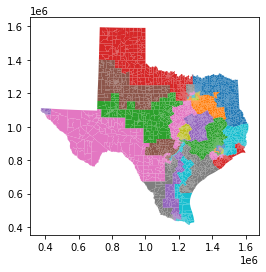

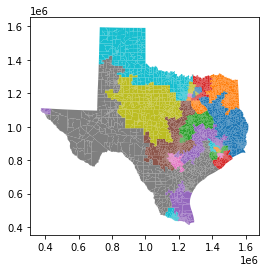

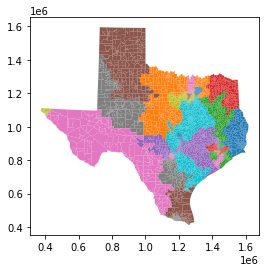

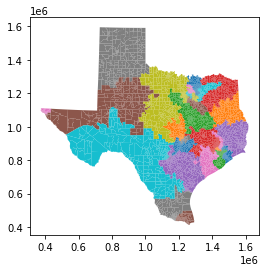

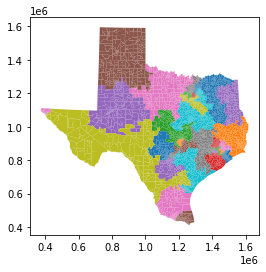

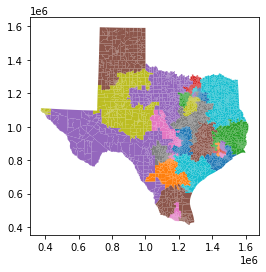

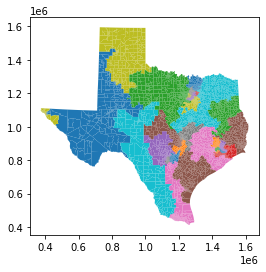

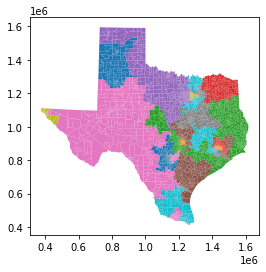

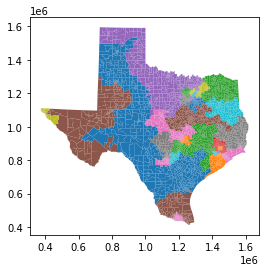

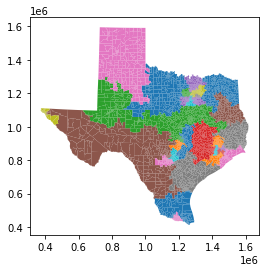

In [ ]:
for partition in chain:
    #plots and prints every 100th map, helpful also for tracking progress
    if(i%100==0):
        partition.plot()
        plt.savefig("mapstep"+str(i)+".png")
    #store the results from all elections
    election_data.loc[i] = {election.name: sorted(partition[election.name].percents("Democratic")) for election in elections}
    #calculate the proportion non-white VAP in each district
    demo_data.loc[i] = {(partition["VAP"][key] - partition["WVAP"][key])/partition["VAP"][key] for key in partition["population"] }
    #add an array of gini scores 
    gini.append([metrics.partisan_gini(partition[election.name]) for election in elections])
    i = i+1

**el** is a variable that stores the name of the election we would like to analyze, here the 2014 Governor's race, but you can change it to any of the Election names above. Here we extract that particular election data in a form suitable for plotting

In [ ]:
el = "PRES16"

num_dist = len(election_data[el].iloc[0])

percents = []

for i in range(0,n):
    #fills in election information for chosen election in plan i
    percents.append(sorted(election_data[el].loc[i][j] for j in range(0,num_dist))) 

percents = numpy.asarray(percents)

In [ ]:
percents

array([[0.17417408, 0.19689824, 0.22414626, ..., 0.79300755, 0.81228329,
        0.81480705],
       [0.17417408, 0.19689824, 0.22414626, ..., 0.79300755, 0.81228329,
        0.81480705],
       [0.17417408, 0.19689824, 0.22414626, ..., 0.77139699, 0.81228329,
        0.81480705],
       ...,
       [0.17394316, 0.21580553, 0.21906791, ..., 0.72486026, 0.78093477,
        0.792243  ],
       [0.17394316, 0.21580553, 0.21906791, ..., 0.72486026, 0.78093477,
        0.792243  ],
       [0.17394316, 0.21580553, 0.21906791, ..., 0.72486026, 0.78093477,
        0.792243  ]])

The following code processes minority voting age population as a percent of total voting age population in each district in each partition

In [ ]:
mvap = []
districts = []

for i in range(0,n):
    #calculates the number of districts in plan i with MVAP proportion
    M = numpy.array(list(demo_data["MVAP"][i]))
    mvap.append(M)
    M = (M+0.5).astype('int')
    districts.append(sum(M))

mvap = numpy.asarray(mvap)
gini = numpy.asarray(gini)
gini.T


array([[0.06589929, 0.06476005, 0.06674268, ..., 0.03609343, 0.03622421,
        0.03573627],
       [0.07780919, 0.07688536, 0.07852236, ..., 0.04077491, 0.04080934,
        0.04032982],
       [0.07821214, 0.076898  , 0.07897554, ..., 0.04388567, 0.04390359,
        0.04343133],
       [0.08419829, 0.08318891, 0.08469146, ..., 0.04086904, 0.04098619,
        0.04050984],
       [0.05097846, 0.04992215, 0.05059542, ..., 0.03069232, 0.03061401,
        0.03062655]])

Next we plot the election results, here a boxplot of Democratic vote percentage.

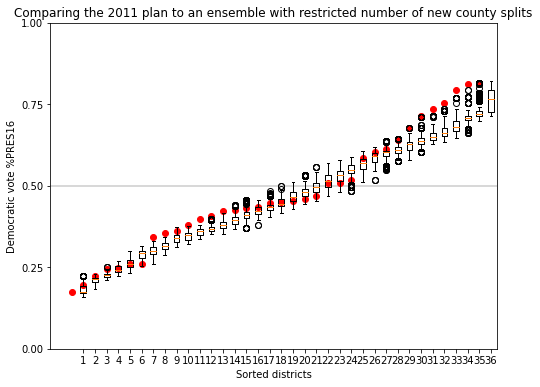

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
#pt_asarray.boxplot(ax=ax, positions=range(0, len(pt_dt.columns)))
#plt.boxplot(pt_asarray)

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)


percents.T
plt.plot(percents[0], "ro")
plt.boxplot(percents)

# Annotate
ax.set_title("Comparing the 2011 plan to an ensemble with restricted number of new county splits")
ax.set_ylabel("Democratic vote %"+el)
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
#this command outputs a figure and clears the plot
plt.show()


And we can also plot the non-white VAP

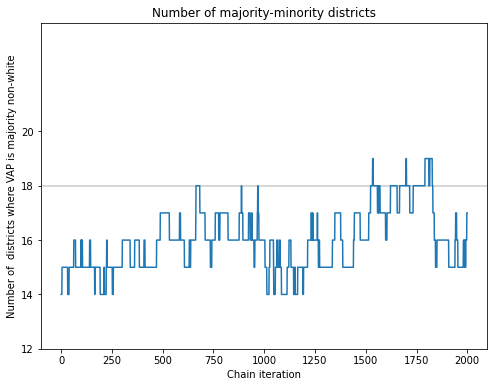

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(18, color="#cccccc")

# Draw boxplot
# pt_asarray.boxplot(ax=ax, positions=range(0, len(pt_dt.columns)))
plt.plot(districts)


# Annotate
ax.set_title("Number of majority-minority districts")
ax.set_ylabel("Number of  districts where VAP is majority non-white")
ax.set_xlabel("Chain iteration")
ax.set_ylim(12, 24)
ax.set_yticks([12,14,16,18,20])

#this command outputs a figure and clears the plot
plt.show()

Partisan gini scores

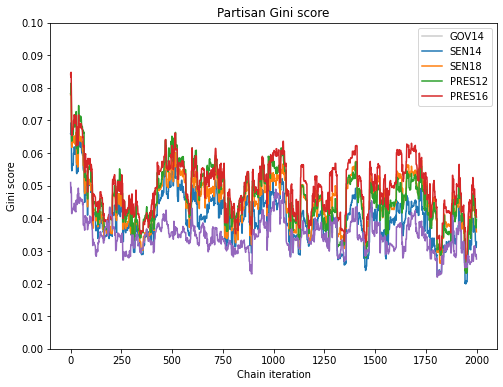

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(18, color="#cccccc")

# Draw boxplot
# pt_asarray.boxplot(ax=ax, positions=range(0, len(pt_dt.columns)))
plt.plot(gini)


# Annotate
ax.set_title("Partisan Gini score")
ax.set_ylabel("Gini score")
ax.set_xlabel("Chain iteration")
ax.set_ylim(0,0.1)
ax.set_yticks([0,0.01,.02,.03,.04,.05,.06,.07,.08,.09,.1])

ax.legend(['GOV14','SEN14','SEN18','PRES12','PRES16'])

#this command outputs a figure and clears the plot
plt.show()